In [ ]:
!pip install torch torchvision transformers datasets matplotlib pandas scikit-learn wordcloud
!pip install --upgrade --force-reinstall fsspec datasets

  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)
  Using cached datasets-3.6.0-py3-none-any.whl.metadata (19 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached numpy-2.3.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached pyarrow-20.0.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (3.3 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached pandas-2.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (91 kB)
  Using cached requests-2.32.4-py3-none-any.whl.metadata (4.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached xxhash-3.5.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.16-py311-none-any.whl.metadata (7.2 kB)
  Using cached fsspec-2025.3.0-py3-none-any.whl.metadata (11 kB)
  Using cached huggingface_hub-0.33.2-py3-none-any.whl.metadata (14 kB)
  Using cached packaging-25.0-py

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from datasets import load_dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import random

plt.style.use('seaborn-v0_8-ticks')

In [ ]:
def get_device():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Using device:", device)
    return device

In [ ]:
def subsample_balanced(df, n_per_class):
    return (
        df.groupby('label', group_keys=False)
        .apply(lambda x: x.sample(n=n_per_class, random_state=42))
        .reset_index(drop=True)
    )

In [ ]:
def plot_class_distribution(df, colors):
    plt.figure(figsize=(5,3))
    df['label'].value_counts().plot(kind='bar', color=colors, edgecolor='#18020c')
    plt.title('IMDB Class Balance', fontsize=13, color='#560bad')
    plt.xlabel('Sentiment (0=Neg, 1=Pos)')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

In [ ]:

def plot_length_histogram(df, color):
    plt.figure(figsize=(6,2.8))
    df['num_words'] = df['text'].apply(lambda t: len(t.split()))
    plt.hist(df['num_words'], bins=30, color=color, edgecolor='#22223b', alpha=0.85)
    plt.title('Review Word Count Distribution', fontsize=11, color='#fb8b24')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_wordcloud(df, label, cmap, title, tcolor):
    text_blob = " ".join(df[df['label'] == label]['text'])
    wc = WordCloud(width=700, height=200, background_color='white', colormap=cmap).generate(text_blob)
    plt.figure(figsize=(7,2.6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=12, color=tcolor)
    plt.tight_layout()
    plt.show()

In [ ]:
def get_bert_dataset(texts, labels, tokenizer, maxlen):
    class IMDBBertDataset(Dataset):
        def __init__(self, texts, labels, tokenizer, maxlen):
            self.texts = texts
            self.labels = labels
            self.tokenizer = tokenizer
            self.maxlen = maxlen
        def __len__(self):
            return len(self.texts)
        def __getitem__(self, idx):
            enc = self.tokenizer(
                str(self.texts[idx]),
                truncation=True,
                padding='max_length',
                max_length=self.maxlen,
                return_tensors='pt'
            )
            batch = {k: v.squeeze(0) for k, v in enc.items()}
            batch['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
            return batch
    return IMDBBertDataset(texts, labels, tokenizer, maxlen)


In [ ]:
def train_bert(model, loader, optimizer, device, epochs):
    model.train()
    loss_history = []
    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labs = batch['labels'].to(device)
            optimizer.zero_grad()
            out = model(input_ids=ids, attention_mask=mask, labels=labs)
            loss = out.loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")
    return loss_history

In [ ]:
def plot_training_loss(loss_history, color):
    plt.figure(figsize=(6,3.2))
    plt.plot(range(1, len(loss_history)+1), loss_history, marker='s', color=color, linewidth=2)
    plt.title('Training Loss Curve', fontsize=13, color='#00b4d8')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.tight_layout()
    plt.show()


In [ ]:
def evaluate_bert(model, loader, device):
    model.eval()
    all_preds = []
    all_true = []
    with torch.no_grad():
        for batch in loader:
            ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labs = batch['labels'].to(device)
            outs = model(input_ids=ids, attention_mask=mask)
            preds = torch.argmax(outs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_true.extend(labs.cpu().numpy())
    return np.array(all_true), np.array(all_preds)


In [ ]:
def plot_cm(true_labels, pred_labels, class_names, cmap):
    cm = confusion_matrix(true_labels, pred_labels)
    fig, axis = plt.subplots(figsize=(5.5,4.5))
    cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    cm_disp.plot(cmap=cmap, ax=axis, colorbar=True)
    plt.title('IMDB Confusion Matrix', fontsize=14, color='#3c096c')
    plt.xlabel('Predicted', fontsize=12, color='#fb8b24')
    plt.ylabel('True', fontsize=12, color='#fb8b24')
    plt.xticks(fontsize=11, color='#212529')
    plt.yticks(fontsize=11, color='#212529')
    plt.grid(False)
    plt.tight_layout()
    plt.show()


In [ ]:
def print_random_preds(test_texts, test_labels, pred_labels, n=5):
    idxs = random.sample(range(len(test_texts)), n)
    print("\nRandom sample predictions:")
    for idx in idxs:
        snippet = test_texts[idx][:90].replace('\n', ' ')
        print(f"\nReview: {snippet}...")
        print(f"True: {'Positive' if test_labels[idx] == 1 else 'Negative'} | Predicted: {'Positive' if pred_labels[idx] == 1 else 'Negative'}")


Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

/tmp/ipython-input-4-3975479143.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=n_per_class, random_state=42))
/tmp/ipython-input-4-3975479143.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=n_per_class, random_state=42))


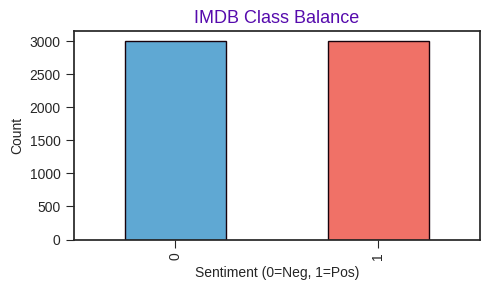

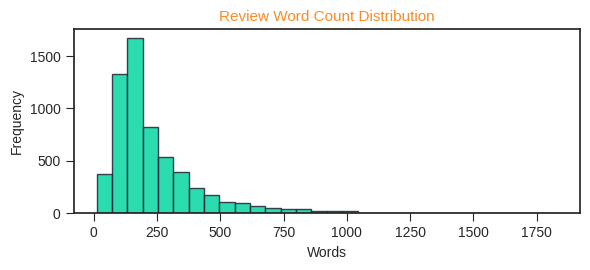

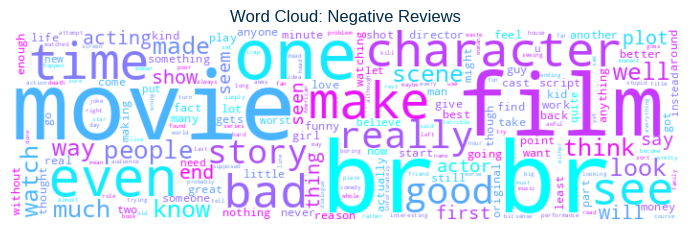

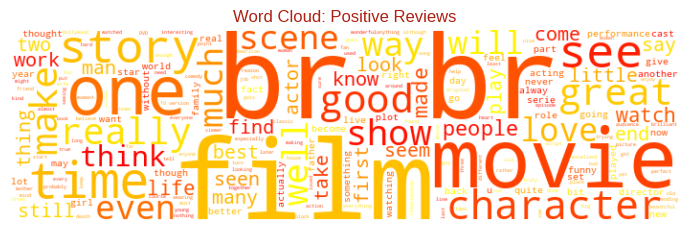

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10 - Loss: 0.4170
Epoch 2/10 - Loss: 0.2177
Epoch 3/10 - Loss: 0.1154
Epoch 4/10 - Loss: 0.0632
Epoch 5/10 - Loss: 0.0397
Epoch 6/10 - Loss: 0.0317
Epoch 7/10 - Loss: 0.0243
Epoch 8/10 - Loss: 0.0175
Epoch 9/10 - Loss: 0.0297
Epoch 10/10 - Loss: 0.0149


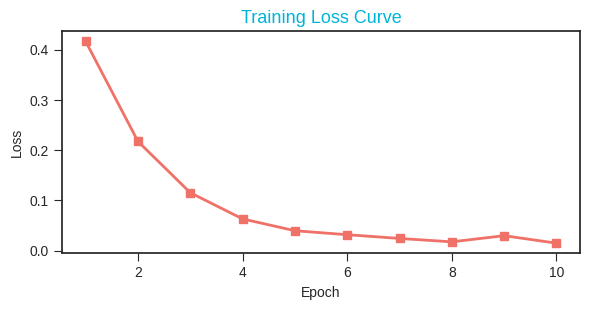


Test Accuracy: 0.8400
Test F1 Score: 0.8515


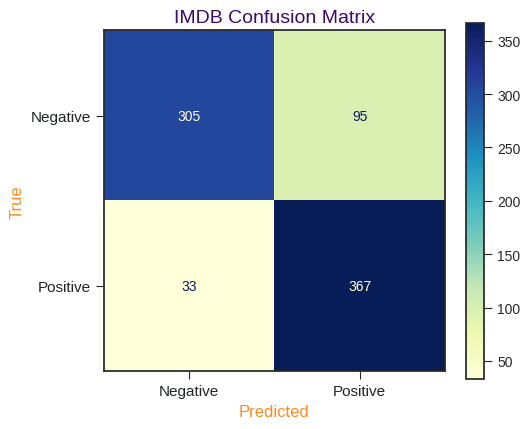


Random sample predictions:

Review: I really, really don't understand how that movie could get a rating bigger than 4 here on ...
True: Negative | Predicted: Negative

Review: "I hate you, you hate me, Barney stole your SUV with a great big bunch and a kick from me ...
True: Negative | Predicted: Negative

Review: Supernanny Jo Frost, in each episode, gives a family the benefit of her hard-earned experi...
True: Positive | Predicted: Positive

Review: First, I would like to apologize for my rating of "1"... The only reason i give this film ...
True: Negative | Predicted: Negative

Review: It's hard to believe a movie can be this bad, but you live and learn. What's more amazing ...
True: Negative | Predicted: Positive


In [ ]:
# --- MAIN WORKFLOW ---
def main():
    # Device
    device = get_device()

    # Data
    imdb_raw = load_dataset("imdb")
    reviews_train_df = pd.DataFrame(imdb_raw['train'])
    reviews_test_df = pd.DataFrame(imdb_raw['test'])

    # Balanced, small subsample for speed
    reviews_train_df = subsample_balanced(reviews_train_df, 3000)
    reviews_test_df = subsample_balanced(reviews_test_df, 400)

    # Visualization
    plot_class_distribution(reviews_train_df, ['#5fa8d3', '#f07167'])
    plot_length_histogram(reviews_train_df, '#06d6a0')
    plot_wordcloud(reviews_train_df, 0, 'cool', 'Word Cloud: Negative Reviews', '#012a4a')
    plot_wordcloud(reviews_train_df, 1, 'autumn', 'Word Cloud: Positive Reviews', '#ae2012')

    # Tokenizer and datasets
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    max_len = 128

    train_dataset = get_bert_dataset(reviews_train_df['text'].tolist(), reviews_train_df['label'].tolist(), tokenizer, max_len)
    test_dataset = get_bert_dataset(reviews_test_df['text'].tolist(), reviews_test_df['label'].tolist(), tokenizer, max_len)

    train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=12)

    # Model, optimizer
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)
    optimizer = AdamW(model.parameters(), lr=2e-5)

    # Training
    loss_history = train_bert(model, train_loader, optimizer, device, epochs=10)
    plot_training_loss(loss_history, '#f07167')

    # Evaluation
    y_true, y_pred = evaluate_bert(model, test_loader, device)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"\nTest Accuracy: {acc:.4f}")
    print(f"Test F1 Score: {f1:.4f}")

    # Confusion Matrix
    plot_cm(y_true, y_pred, ['Negative', 'Positive'], cmap='YlGnBu')

    # Print 5 random predictions
    print_random_preds(reviews_test_df['text'].tolist(), reviews_test_df['label'].tolist(), y_pred, n=5)

main()